In [1]:
import pandas as pd
import numpy as np
import utils as ut # esta librería tiene funciones para poder obtener un procesamiento del <T,H>
import spacy
import mutual_info as mi
import time
from scipy.stats import wasserstein_distance,entropy
import sys
from math import floor

/home/david/anaconda3/envs/rit/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import conceptnet_lite
conceptnet_lite.connect("../OPENAI/data/conceptnet.db")
from conceptnet_lite import Label, edges_for, edges_between

In [3]:
def obtener_distancia(texto_v,hipotesis_v,texto_t,texto_h,b_col,b_index):
    lista_l=[]
    for i in range(len(texto_t)):
        lista=[]
        for j in range(len(texto_h)):
            lista.append(np.linalg.norm(texto_v[i] - hipotesis_v[j]))#*wasserstein_distance(texto_2[i],hipotesis_2[j]))
        lista_l.append(lista)
    df_distEuc=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    df_distEuc=df_distEuc.drop(b_col[1:],axis=1)
    df_distEuc=df_distEuc.drop(b_index[1:],axis=0)
    return df_distEuc

In [4]:
def wasserstein_mutual_inf(texto_v,hipotesis_v,texto_t,texto_h):  
    lista_l=[]
    lista_muinfor=[]   
    for i in range(len(texto_t)):
        lista=[]
        lista_mu=[]
        for j in range(len(texto_h)):
            lista.append(wasserstein_distance(texto_v[i],hipotesis_v[j]))
            lista_mu.append(mi.mutual_information_2d(np.array(texto_v[i]),np.array(hipotesis_v[j])))
        lista_l.append(lista)
        lista_muinfor.append(lista_mu)
    DFmearth=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    DFmutual_inf=pd.DataFrame(lista_muinfor,index=texto_t,columns=texto_h)
    return DFmearth,DFmutual_inf

In [5]:
def entropia(X):
    """Devuelve el valor de entropia de una muestra de datos""" 
    probs = [np.mean(X == valor) for valor in set(X)]
    print("Valores para entropia",set(X))
    print("Probabilidades",probs)
    #return round(sum(-p * np.log2(p) for p in probs), 3)
    return entropy(probs,base=2)

In [6]:
entropia(np.array([1,2,2,2,2,2,2,2,2,0,3]))

Valores para entropia {0, 1, 2, 3}
Probabilidades [0.09090909090909091, 0.09090909090909091, 0.7272727272727273, 0.09090909090909091]


1.2776134368191157

In [7]:
def kullback_leibler(X,Y):
    """Devuelve el valor de entropia de una muestra de datos""" 
    probsX = [np.mean(X == valor) for valor in set(X)]
    print("Valores para entropia",set(X))
    print("Probabilidades",probsX)
    probsY = [np.mean(Y == valor) for valor in set(X)]
    print("Valores para entropia",set(X))
    print("Probabilidades",probsY)
    #return round(sum(-p * np.log2(p) for p in probs), 3)
    return entropy(probsY,probsX,base=2)

In [8]:
kullback_leibler(np.array([1,2,2,2,3]),np.array([1,2,2,2]))

Valores para entropia {1, 2, 3}
Probabilidades [0.2, 0.6, 0.2]
Valores para entropia {1, 2, 3}
Probabilidades [0.25, 0.75, 0.0]


0.32192809488736235

In [9]:
relaciones_generales=["is_a","part_of","used_for", "capable_of", "at_location","etymologically_related_to","manner_of","has_a","derived_from","has_property","form_of","causes","has_prerequisite","has_subevent","has_first_subevent"]
relaciones_especificas=["is_a","manner_of","has_a","derived_from","has_property","form_of","causes","has_prerequisite","has_subevent","has_first_subevent"]

In [10]:
def bag_of_synonyms(word):
    sinonimos=set()
    try:
        for e in edges_for(Label.get(text=word, language='en').concepts, same_language=True):
            if e.relation.name == "synonym":
                if word== e.start.text:
                    sinonimos.add(e.end.text)
                elif word== e.end.text:
                    sinonimos.add(e.start.text)
    except:
        pass
    sinonimos.add(word)
    return sinonimos

def bag_of_antonyms(word):
    antonimos=set()
    try:
        for e in edges_for(Label.get(text=word, language='en').concepts, same_language=True):
            if e.relation.name in ["antonym","distinc_from"]:
                if word== e.start.text:
                    antonimos.add(e.end.text)
                elif word== e.end.text:
                    antonimos.add(e.start.text)
    except:
        pass
    return antonimos

def bag_of_hyperonyms(word):
    hiperonimos=set()
    try:
        for e in edges_for(Label.get(text=word, language='en').concepts, same_language=True):
            if e.relation.name in relaciones_generales:
                if word== e.start.text:
                    hiperonimos.add(e.end.text)
    except:
        pass
    return hiperonimos

def bag_of_hyponyms(word):
    hiponimos=set()
    try:
        for e in edges_for(Label.get(text=word, language='en').concepts, same_language=True):
            if e.relation.name in relaciones_especificas:
                if word== e.end.text:
                    hiponimos.add(e.start.text)
                    #print(e.relation.name,e.start.text)
    except:
        pass
    return hiponimos

In [11]:
def jaro_distance(s1, s2,sinT,sinH,HipT,hipH) :
    bandera=True

    # Length of two strings
    len1 = len(s1)
    len2 = len(s2)

    # If the listas de tokens are equal 
    if len1==len2:
        for i in range(len1):
            if s1[i]!=s2[i]:
                bandera=False
                break
        if (bandera):
            return 1.0; 
 
    if (len1 == 0 or len2 == 0) :
        return 0.0; 
 
    # Maximum distance upto which matching 
    # is allowed 
    max_dist = (max(len(s1), len(s2)) // 2 )-1 ; 
 
    # Count of matches 
    match = 0; 
 
    # Hash for matches 
    hash_s1 = [0] * len(s1)
    hash_s2 = [0] * len(s2)
 
    # Traverse through the first string 
    for i in range(len1):
 
        # Check if there is any matches
        for j in range(max(0, i - max_dist), 
                       min(len2, i + max_dist + 1)):
            print(s1[i],s2[j])
            # If there is a match or is contain in a bag of sinomys of tk
            if ((s1[i] == s2[j] or s1[i] in sinH[j] or s2[j] in sinT[i]) and hash_s2[j] == 0) : 
                print(s1[i],s2[j],"sinonimos")
                hash_s1[i] += 1; 
                hash_s2[j] += 1; 
                match += 1; 
                break
            elif ((s1[i] in hipH[j] or len((sinT[i]).intersection(hipH[j]))>0) and hash_s2[j] == 0):
                print("hiponimos",s2[j],s1[i],(sinT[i]).intersection(hipH[j]))
                hash_s1[i] += 1; 
                hash_s2[j] += 1; 
                match += 1; 
                break
            elif ((s2[j] in HipT[i] or len((sinH[j]).intersection(HipT[i]))>0) and hash_s2[j] == 0): 
                print("hiperonimos sobre sinonimos",s2[j],s1[i])
                hash_s1[i] += 1; 
                hash_s2[j] += 1; 
                match += 1; 
                break
            # elif len((hipH[j]).intersection(HipT[i]))>0 and hash_s2[j] == 0: 
            #     print("hiperonimos3",s2[j],s1[i],(hipH[j]).intersection(HipT[i]))
            #     hash_s1[i] += 1; 
            #     hash_s2[j] += 1; 
            #     match += 1; 
            #     break
            
    print(hash_s1)
    print(hash_s2)
    print(match)
    # If there is no match 
    if (match == 0) :
        return 0.0; 
 
    # Number of transpositions 
    t = 0; 
 
    point = 0; 
 
    # Count number of occurrences 
    # where two characters match but 
    # there is a third matched character 
    # in between the indices 
    for i in range(len1) : 
        if (hash_s1[i]) :
            # Find the next matched character 
            # in second string 
            while (hash_s2[point] == 0) :
                point += 1; 
 
            if (s1[i] != s2[point]) :
                point += 1
                t += 1
            else :
                point += 1    
    t /= 2; 
    #Return the Jaro Similarity 
    return match / len2; 

In [12]:
def relacion_entailment(wt,wh):
    try:
        concepts_wt = Label.get(text=wt, language='en').concepts
        concepts_wh = Label.get(text=wh, language='en').concepts
        for e in edges_between(concepts_wt, concepts_wh):
            if wt == e.start.text and e.relation.name in relaciones_generales:
                print(e.start.text, "-", e.end.text, "|", e.relation.name,e)
                return True
    except:
        pass
    return False

def relacion_noentailment(wt,wh):
    try:
        concepts_wt = Label.get(text=wt, language='en').concepts
        concepts_wh = Label.get(text=wh, language='en').concepts
        for e in edges_between(concepts_wt, concepts_wh):
            if wt == e.start.text and e.relation.name in ["distinct_from","antonym"]:
                print(e.start.text, "-", e.end.text, "|", e.relation.name,e)
                return True
    except:
        pass
    return False

def relacion_conceptual(wt,wh):
    try:
        concepts_wt = Label.get(text=wt, language='en').concepts
        concepts_wh = Label.get(text=wh, language='en').concepts
        for e in edges_between(concepts_wt, concepts_wh,two_way=True):
            if wt==e.end.text and e.relation.name in relaciones_generales:
                print(e.start.text, "-", e.end.text, "|", e.relation.name,e)
                return True
            elif e.relation.name in ["related_to","similar_to"]:
                print(e.start.text, "-", e.end.text, "|", e.relation.name,e)
                return True
    except:
        pass
    return False

In [13]:
def negacion(nlp,texto):
    b=1.0
    if (type(texto)==type(b) or texto=="" or texto=="n/a" or texto=="nan"):
        return 0,""
    doc = nlp(texto.lower())
    for token in doc:
        if(token.dep_=="neg"):
            return 1, token.head.lemma_
    return 0,""

def representacion_entidades(nlp,texto):
    dir_sust=dict()
    palabras=[]
    b=1.0
    if (type(texto)==type(b) or texto=="" or texto=="n/a" or texto=="nan"):
        return dir_sust,palabras
    doc =nlp(texto.lower())
    for token in doc:
        if token.dep_ in tags:
            #print(token.text, token.lemma_, token.pos_,token.dep_,token.head.text,token.head.lemma_, token.head.pos_,
            #    [child for child in token.children])
            #sustantivos.append(token.head.lemma_)
            if token.head.lemma_ in dir_sust:
                if dir_sust[token.head.lemma_]=="NA":
                    dir_sust[token.head.lemma_]=token.lemma_
                    if token.head not in palabras:
                        palabras.append(token.head)
                else:
                    dir_sust[token.head.lemma_]=dir_sust[token.head.lemma_]+","+token.lemma_
                    if token.head not in palabras:
                        palabras.append(token.head)
            else:
                dir_sust[token.head.lemma_]=token.lemma_
                if token.head not in palabras:
                    palabras.append(token.head)
        elif token.pos_ in ["NOUN","PROPN"]:
            #print(token.text,token.lemma_, token.pos_,token.dep_)
            #sustantivos.append(token.lemma_)
            if token.lemma_ not in dir_sust:
                dir_sust[token.lemma_]="NA"
                if token not in palabras:
                    palabras.append(token)
        elif token.pos_ in ["VERB"]:
            #print(token.text, token.lemma_,token.pos_,token.dep_)
            #sustantivos.append(token.lemma_)
            if token.lemma_ not in dir_sust:
                dir_sust[token.lemma_]="NA"
                if token not in palabras:
                    palabras.append(token)
        else:
            print(token.text)
    return dir_sust,palabras

def representacion2(nlp,texto):
    doc = nlp(texto.lower())
    dir_sust=dict()
    palabras=[]
    noun_phrase= [chunk.lemma_ for chunk in doc.noun_chunks]
    verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    for chunk in doc.noun_chunks:
        if chunk.root.lemma_!=chunk.lemma_:
            dir_sust[chunk.root.lemma_]=','.join(chunk.lemma_.split()[:-1])
        else:
            dir_sust[chunk.root.lemma_]="NA"
    palabras.extend([chunk.root.lemma_ for chunk in doc.noun_chunks])
    palabras.extend(verbs)
    return dir_sust,palabras

deps_tags=["relcl","prep","amod","compound","pobj","conj","nsubj","advcl","dobj","neg",'acomp',"attr", 'nummod',"oprd","npadvmod"]
palabras_no=["wear","dress","clothe"]
def representacion(nlp,texto):
    dir_sust=dict()
    palabras=[]
    b=1.0
    if (type(texto)==type(b) or texto=="" or texto=="n/a" or texto=="nan"):
        return dir_sust,palabras
    doc =nlp(texto)
    # poses=[]
    # tokens=[]
    # lemmas=[]
    # children=[]
    # verb_vincu=[]
    # deps=[]
    dir_sust=dict()
    palabras=[]
    frase=""
    anterior="det"
    nsubj=""
    for token in doc:
        #print(token.text, token.dep_, token.head.text, token.head.pos_,
        #    [child for child in token.children])
        # poses.append(token.pos_)
        # tokens.append(token.text)
        # lemmas.append(token.lemma_)
        # verb_vincu.append(token.head.lemma_)
        # deps.append(token.dep_)
        # children.append([child for child in token.children])
        # print(token.text,token.pos_,token.dep_)
        if token.lemma_ not in palabras_no:
            if token.dep_ in deps_tags or (token.dep_=="ROOT" and token.pos_=="NOUN"):
                if token.dep_=="nsubj": 
                    if nsubj=="":
                        frase= frase + " " + token.lemma_ 
                        nsubj=token.lemma_
                    else:
                        if frase!="":
                            palabras.append(frase.split()[-1])
                            if len(frase.split())>1:
                                dir_sust[frase.split()[-1]]=','.join(frase.split()[0:-1])
                            else:
                                dir_sust[frase.split()[-1]]="NA"
                        frase=""
                elif token.dep_=="prep":
                    if token.lemma_ not in ["in","at","on","with","from","to","for","since"]:    
                        frase= frase + token.lemma_ + " "
                    else:
                        if frase!="":
                            palabras.append(frase.split()[-1])
                            if len(frase.split())>1:
                                dir_sust[frase.split()[-1]]=','.join(frase.split()[0:-1])
                            else:
                                dir_sust[frase.split()[-1]]="NA"
                        frase=""
                elif token.dep_=="neg":
                    frase= frase + " "+ token.lemma_
                else:
                    
                    frase= frase + " "+ token.lemma_
            elif token.dep_ in ["ROOT"] and token.pos_ in ["VERB"] and anterior=="NUM":
                #palabras.append(frase+" "+token.lemma_)
                palabras.append(token.lemma_)
                frase=""
            elif token.dep_ in ["ROOT"] and token.pos_ in ["VERB"]:
                if frase!="":
                    palabras.append(frase.split()[-1])
                    if len(frase.split())>1:
                        dir_sust[frase.split()[-1]]=','.join(frase.split()[0:-1])
                    else:
                        dir_sust[frase.split()[-1]]="NA"
                    palabras.append(token.lemma_)
                    dir_sust[token.lemma_]="NA"
                else:
                    palabras.append(token.lemma_)
                    dir_sust[token.lemma_]="NA"
                frase=""
            else:
                #print(frase)
                if frase!="":
                    palabras.append(frase.split()[-1])
                    if len(frase.split())>1:
                        dir_sust[frase.split()[-1]]=','.join(frase.split()[0:-1])
                    else:
                        dir_sust[frase.split()[-1]]="NA"
                frase=""
        anterior=token.pos_
    if frase!="":
        palabras.append(frase.split()[-1])
        if len(frase.split())>1:
            dir_sust[frase.split()[-1]]=','.join(frase.split()[0:-1])
        else:
            dir_sust[frase.split()[-1]]="NA"
    # poses.append("<F>")
    # tokens.append("</F>")
    # lemmas.append("</F>")
    # children.append("</F>")
    # verb_vincu.append("</F>")
    # deps.append("</F>")
    # print("tokens",tokens)
    # print("poses",poses)
    # print("lemmas",lemmas)#
    # print("children",children)
    # print("verbos_vinculantes",verb_vincu)#
    # print("deps",deps)
    return dir_sust,palabras

In [14]:

tags=[ 'acl',
 'acomp',
 'advcl',
 'advmod',
 'amod',
 'appos',
 'ccomp',
 'complm',
 'compound',
 'conj',
 'infmod',
 'meta',
 'neg',
 'nmod',
 'nn',
 'npadvmod',
 'nounmod',
 'npmod',
 'num',
 'number',
 'nummod',
 'partmod',
 'pcomp',
 'poss',
 'possessive',
 'prep',
 'quantmod',
 'rcmod',
 'relcl',
 'xcomp',
 'adc',
 'avc',
 'mnr',
 'mo',
 'ng',
 'nmc'
]

In [15]:
nlp = spacy.load("en_core_web_md") # modelo de nlp

#ut.load_vectors_in_lang(nlp,"../OPENAI/data/glove.840B.300d.txt") # carga de vectores en nlp.wv
ut.load_vectors_in_lang(nlp,"./data/numberbatch-en-17.04b.txt") # carga de vectores en nlp.wv


In [16]:
# lista de listas para dataframe
new_data = { 'distancias' : [], 'entropia_total' : [],'entropias' : [],
            'mutinf' : [], 'mearts' : [], 'max_info' : [], 'sumas' : [],
            'mutinf_t' : [], 'mearts_t' : [], 'max_info_t' : [], 'sumas_t' : [],
            'entail':[],'contra':[],'neutral':[],'no_match':[],'rel_conceptuales':[],
            'list_comp' : [], 'diferencias' :[], 'list_incomp':[], 'entropia_relaciones':[],
            'list_M' : [], 'list_m' : [], 'list_T' : [], 'Jaro-Winkler_rit':[], 'KL_divergence':[],
            'negT' : [], 'verbT' : [], 'negH' : [], 'verbH':[], 'overlap_ent':[],'clases' : []}

In [17]:
# cargar los conjuntos de sinonimos, hyperonimos e hyponimos
diccionario_sinonimos=dict()
diccionario_hiperonimos=dict()
diccionario_hyponimos=dict()
#diccionario_antonimos=dict()

df_temp=pd.read_pickle("salida/nuevo4a/Synonyms.pickle")
for index,strings in df_temp.iterrows():
    diccionario_sinonimos[strings['word']]=strings['Synonym']

df_temp=pd.read_pickle("salida/nuevo4a/Hyperonyms.pickle")
for index,strings in df_temp.iterrows():
    diccionario_hiperonimos[strings['word']]=strings['Hyperonym']

df_temp=pd.read_pickle("salida/nuevo4a/Hyponyms.pickle")
for index,strings in df_temp.iterrows():
    diccionario_hyponimos[strings['word']]=strings['Hyponym']

In [22]:
textos=["A person in orange clothing rests above a metro entrance."]
hipotesis= ["Someone is standing near a metro station"]

In [74]:
# from sentence_transformers import SentenceTransformer,util
# modelSB = SentenceTransformer('all-MiniLM-L6-v2')

In [75]:
# emb1 = modelSB.encode("station")
# emb2 = modelSB.encode("metro")
# #Get the cosine similarity score between sentences
# cos_sim = util.cos_sim(emb1, emb2)
# print(float(cos_sim[0][0]))
# #agregar esta parte

0.4859835207462311


In [23]:
inicio = time.time()
for i in range(len(textos)):
#for i in range(4):
    print(i)
    print(textos[i])
    r_t,t_clean_m=representacion_entidades(nlp,textos[i])
    # #r_t,t_clean_m=representacion2(nlp,textos[i])
    #r_t,t_clean_m=representacion(nlp,textos[i])
    neg_t,negadat=negacion(nlp,textos[i])
    new_data['negT'].append(neg_t)
    new_data['verbT'].append(negadat)
    # #print(list(r_t.keys()))
    # for clave in r_t.keys():
    #     print("texto",clave,r_t[clave])
    print(hipotesis[i])
    r_h,h_clean_m = representacion_entidades(nlp,hipotesis[i])
    # #r_h,h_clean_m = representacion2(nlp,hipotesis[i])
    #r_h,h_clean_m = representacion(nlp,hipotesis[i])
    neg_h,negadah=negacion(nlp,hipotesis[i])
    new_data['negH'].append(neg_h)
    new_data['verbH'].append(negadah)
    # for clave in r_h.keys():
    #     print("hipotesis",clave,r_h[clave])
    if len(set(h_clean_m))!=0 and len(set(t_clean_m))!=0:
        new_data['overlap_ent'].append(len(set(t_clean_m).intersection(set(h_clean_m)))/len(set(h_clean_m)))
    else:
        new_data['overlap_ent'].append(0)
    t_lem=list(set(ut.get_lemmas_(textos[i],nlp)))
    h_lem=list(set(ut.get_lemmas_(hipotesis[i],nlp)))
    t_vectors=ut.get_matrix_rep2(t_lem, nlp, normed=False)
    h_vectors=ut.get_matrix_rep2(h_lem, nlp, normed=False)
    t_vectors_n=ut.get_matrix_rep2(t_lem, nlp, normed=True)
    h_vectors_n=ut.get_matrix_rep2(h_lem, nlp, normed=True)
    
    # print(t_vectors)
    # print(h_vectors)
    # print(t_clean_m,h_clean_m)
    
    # s1=t_clean_m.split()
    # s2=h_clean_m.split()
    for t in t_lem:
        if t not in diccionario_sinonimos:
            diccionario_sinonimos[t]=bag_of_synonyms(t)
        if t not in diccionario_hiperonimos:
            diccionario_hiperonimos[t]=bag_of_hyperonyms(t)
        if t not in diccionario_hyponimos:
            diccionario_hyponimos[t]=bag_of_hyponyms(t)
        # if t not in diccionario_antonimos:
        #     diccionario_antonimos[t]=bag_of_antonyms(t)
    for t in h_lem:
        if t not in diccionario_sinonimos:
            diccionario_sinonimos[t]=bag_of_synonyms(t)
        if t not in diccionario_hiperonimos:
            diccionario_hiperonimos[t]=bag_of_hyperonyms(t)
        if t not in diccionario_hyponimos:
            diccionario_hyponimos[t]=bag_of_hyponyms(t)
        # if t not in diccionario_antonimos:
        #     diccionario_antonimos[t]=bag_of_antonyms(t)

    s1=t_lem
    s2=h_lem
    
    sinT=[]
    antT=[]
    HipT=[]
    sinH=[]
    antH=[]
    HipH=[]
    hipH=[]
    
    # # encontrar bolsa de sinonimos de cada token
    for t in s1:
        sinT.append(diccionario_sinonimos[t])
        HipT.append(diccionario_hiperonimos[t])

    for h in s2:
        sinH.append(diccionario_sinonimos[h])
        hipH.append(diccionario_hyponimos[h])

    print(t_lem)
    print(h_lem)
    tp1=jaro_distance(t_lem, h_lem,sinT,sinH,HipT,hipH)
    new_data['Jaro-Winkler_rit'].append(tp1)

    # # Obtencion de matriz de alineamiento, matriz de move earth y mutual information
    ma=np.dot(t_vectors_n,h_vectors_n.T)
    #print(t_clean,h_clean)
    #print(len(t_vectors_n),len(h_vectors_n),len(t_clean),len(h_clean))
    m_earth,m_mi=wasserstein_mutual_inf(t_vectors_n,h_vectors_n,t_lem,h_lem)
    ma=pd.DataFrame(ma,index=t_lem,columns=h_lem)
    #print(ma)
    new_data['max_info_t'].append(ma.max().sum()/(ma.shape[1]))#
    new_data['sumas_t'].append(ma.sum().sum()/((ma.shape[1]*(ma.shape[0]))))#
    new_data['mearts_t'].append(m_earth.min().sum()/(ma.shape[1]))# 
    new_data['mutinf_t'].append(m_mi.max().sum()/(ma.shape[1]))# 
    # # Calculamos la entropia inicial de la matriz de distancias coseno sobre tokens de T y H
    distX = ma.round(1).values.flatten()
    new_data['entropia_total'].append(entropia(distX)) 

    # ###### BORRADO DE COSAS QUE NO OCUPO, SOLO NOS QUEDAMOS CON INFORMACIÓN DE TIPOS DE PALABRA: NOUN, VERB, ADJ Y ADV
    # # TAMBIÉN OMITIMOS EL VERBO BE DEBIDO A QUE POR LO REGULAR SE UTILIZA COMO AUXILIAR Y ES UN VERBO COPULATIVO
    # # sirve para construir la llamada predicación nominal del sujeto de una oración: 
    # # #el sujeto se une con este verbo a un complemento obligatorio llamado atributo que por lo general determina 
    # # alguna propiedad, estado o equivalencia del mismo, por ejemplo: "Este plato es bueno". "Juan está casado".
    c_compatibilidad=0
    c_incompatibilidad=0
    c_rel_concep=0
    b_col=[0]

    new_data['list_T'].append(ma.shape[0])
    new_data['list_M'].append(ma.shape[1])
    print(ma)
    # val=ma.max().values
    # print("valores maximos",val.round(1))
    # print("entropias de valores maximos",entropia(val.round(1)))

    #procesamiento de cosas que son la misma entidad
    borrar=list(set(t_lem).intersection(set(h_lem)))
    ma = ma.drop(borrar,axis=1)
    m_earth = m_earth.drop(borrar,axis=1)
    m_mi = m_mi.drop(borrar,axis=1)
    b_col.extend(borrar)

    #Como son palabras iguales entonces se agregan como uno que significa una realcion de entailment
    #calculo de relaciones con entropia
    rel_entropia=[]
    for b_c in borrar:
        rel_entropia.append(1)

    # a = ma.idxmax().values
    # b = ma.columns
    top_k=3
    # # #PARA REVISAR SI EXISTEN RELACIONES DE SIMILITUD SEMÁNTICA A TRAVÉS DEL USO DE CONCEPNET
    print("proceso de obtención de generalidad")
    print(ma,ma.columns)
    for c_c in ma.columns:
        print("columna a checar",c_c)
        # filtrar el top 3 de los mejores similitud coseno para cada token de H vs tokens de T que sean mayores a 0
        # una vez que encontremos quien se sale del ciclo
        temp=ma[c_c].sort_values(ascending=False)
        ranks=list(temp[:top_k].index)
        valranks=list(temp[:top_k].values)
        for r_i in range(len(ranks)):
            borrar=[]
            print("acces",c_c,ranks[r_i],valranks[r_i])
            if valranks[r_i]>0:
                r_wt=str(ranks[r_i])
                r_wh=str(c_c)
                if(relacion_entailment(r_wt,r_wh)):
                    borrar.append(r_wh)
                    rel_entropia.append(1)
                    c_compatibilidad+=1
                    break
                else:
                    print("Proceso de conjuntos")
                    sin1=diccionario_sinonimos[r_wt]
                    sin2=diccionario_sinonimos[r_wh]
                    if len(sin1.intersection(sin2))>0:
                        borrar.append(r_wh)
                        c_compatibilidad+=1
                        rel_entropia.append(1)
                        break
                    else:
                        Hip1=set()
                        for e in list(sin1):
                            if e in diccionario_hiperonimos:
                                Hip1=Hip1.union(diccionario_hiperonimos[e])
                            else:
                                b_H=bag_of_hyperonyms(e)
                                Hip1=Hip1.union(b_H)
                                diccionario_hiperonimos[e]=b_H
                        if len(Hip1.intersection(sin2))>0:
                            borrar.append(r_wh)
                            c_compatibilidad+=1
                            rel_entropia.append(1)
                            break
                        else:
                            hip2=set()
                            for e in list(sin2):
                                if e in diccionario_hyponimos:
                                    hip2=hip2.union(diccionario_hyponimos[e])
                                else:
                                    b_H=bag_of_hyponyms(e)
                                    hip2=hip2.union(b_H)
                                    diccionario_hyponimos[e]=b_H                                
                            if len(sin1.intersection(hip2))>0:   
                                borrar.append(r_wh)
                                c_compatibilidad+=1
                                rel_entropia.append(1)
                                break
        ma = ma.drop(borrar,axis=1)
        m_earth = m_earth.drop(borrar,axis=1)
        m_mi = m_mi.drop(borrar,axis=1)
        n_columns = ma.shape[1]
        b_col.extend(borrar)

    # proceso para saber si hay contradiction en los que faltan
    print("proceso de obtención de contradiction")
    print(ma,ma.columns)
    for c_c in ma.columns:
        print("columna a checar para contradicción",c_c)
        # filtrar el top 3 de los mejores similitud coseno para cada token de H vs tokens de T que sean mayores a 0
        # una vez que encontremos quien se sale del ciclo
        temp=ma[c_c].sort_values(ascending=False)
        ranks=list(temp[:top_k].index)
        valranks=list(temp[:top_k].values)
        for r_i in range(len(ranks)):
            borrar=[]
            print("acces",c_c,ranks[r_i],valranks[r_i])
            if valranks[r_i]>0:
                r_wt=str(ranks[r_i])
                r_wh=str(c_c)
                if(relacion_noentailment(r_wt,r_wh)):
                    c_incompatibilidad+=1
                    rel_entropia.append(0)
                    borrar.append(r_wh)
                    break
                #else:
                    # sin1=diccionario_sinonimos[r_wt]
                    # sin2=diccionario_sinonimos[r_wh]
                    # Hip1=set()
                    # for e in list(sin1):
                    #     if e in diccionario_hiperonimos:
                    #         Hip1=Hip1.union(diccionario_hiperonimos[e])
                    #     else:
                    #         b_H=bag_of_hyperonyms(e)
                    #         Hip1=Hip1.union(b_H)
                    #         diccionario_hiperonimos[e]=b_H
                    # Hip2=set()
                    # for e in list(sin2):
                    #     if e in diccionario_hiperonimos:
                    #         Hip2=Hip2.union(diccionario_hiperonimos[e])
                    #     else:
                    #         b_H=bag_of_hyperonyms(e)
                    #         Hip2=Hip2.union(b_H)
                    #         diccionario_hiperonimos[e]=b_H
                    # Hip1=diccionario_hiperonimos[r_wt]
                    # Hip2=diccionario_hiperonimos[r_wh]
                    # if len(Hip1.intersection(Hip2))>0:
                    #     c_incompatibilidad+=1
                    #     rel_entropia.append(0)
                    #     borrar.append(r_wh)
                    #     break

        ma = ma.drop(borrar,axis=1)
        m_earth = m_earth.drop(borrar,axis=1)
        m_mi = m_mi.drop(borrar,axis=1)
        n_columns = ma.shape[1]
        b_col.extend(borrar)

    #proceso para checar las relaciones conceptuales que existen
    print("proceso de obtención de especificidad y conceptuales")
    print(ma,ma.columns)
    for c_c in ma.columns:
        print("columna a checar para especificidad",c_c)
        # filtrar el top 3 de los mejores similitud coseno para cada token de H vs tokens de T que sean mayores a 0
        # una vez que encontremos quien se sale del ciclo
        temp=ma[c_c].sort_values(ascending=False)
        ranks=list(temp[:top_k].index)
        valranks=list(temp[:top_k].values)
        for r_i in range(len(ranks)):
            borrar=[]
            print("accesar a checar conceptuales",c_c,ranks[r_i],valranks[r_i])
            if valranks[r_i]>0:
                r_wt=str(ranks[r_i])
                r_wh=str(c_c)                
                if (relacion_conceptual(r_wt,r_wh)):
                    rel_entropia.append(2)
                    c_rel_concep+=1
                    borrar.append(r_wh)
                    break
        ma = ma.drop(borrar,axis=1)
        m_earth = m_earth.drop(borrar,axis=1)
        m_mi = m_mi.drop(borrar,axis=1)
        n_columns = ma.shape[1]
        b_col.extend(borrar)
    b_index=[0]
    #proceso para checar las no relaciones que existen
    print("proceso de obtención de no relaciones")
    print(ma,ma.columns)
    for c_c in ma.columns:
        rel_entropia.append(3)

    print("rel",np.array(rel_entropia).round(1))
    print("entropia final",entropia(np.array(rel_entropia).round(1)))

    new_data['entail'].append(rel_entropia.count(1)/len(rel_entropia))
    new_data['contra'].append(rel_entropia.count(0)/len(rel_entropia))
    new_data['neutral'].append(rel_entropia.count(2)/len(rel_entropia))
    new_data['no_match'].append(rel_entropia.count(3)/len(rel_entropia))
    new_data['entropia_relaciones'].append(entropia(np.array(rel_entropia).round(1)))
    # #   ALMACENAMIENTO DE TODA LA INFORMACIÓN PROCESADA DE CARACTERÍSTICAS
    m_distancia = obtener_distancia(t_vectors,h_vectors,t_lem,h_lem,b_col,b_index)
    m_earth=m_earth*m_distancia
    if ma.shape[1]==0:
        new_data['entropias'].append(0)
        new_data['KL_divergence'].append(0)
        new_data['max_info'].append(0)
        new_data['sumas'].append(0)
        new_data['mearts'].append(0)
        new_data['mutinf'].append(0)
        new_data['diferencias'].append(0)
        new_data['distancias'].append(0)
    else:
        distY = ma.round(1).values.flatten()
        new_data['entropias'].append(entropia(distY))
        new_data['KL_divergence'].append(kullback_leibler(distX,distY))
        new_data['max_info'].append(ma.max().sum()/(ma.shape[1]))#
        new_data['sumas'].append(ma.sum().sum()/((ma.shape[1]*(ma.shape[0]))))#
        new_data['mearts'].append(m_earth.min().sum()/(ma.shape[1]))# 
        new_data['mutinf'].append(m_mi.max().sum()/(ma.shape[1]))# 
        new_data['diferencias'].append(len(ma.columns)/len(ma.index))
        new_data['distancias'].append(m_distancia.min().sum()/(ma.shape[1])) #cambie de maximas a sumas

    new_data['list_comp'].append(c_compatibilidad)
    new_data['list_incomp'].append(c_incompatibilidad)
    new_data['rel_conceptuales'].append(c_rel_concep)
    new_data['list_m'].append(ma.shape[1])
    new_data['clases'].append(1)
    print(ma)

fin = time.time()
print("Tiempo que se llevo:",round(fin-inicio,2)," segundos")

0
A person in orange clothing rests above a metro entrance.
Someone is standing near a metro station
['person', 'entrance', 'clothing', 'orange', 'rest', 'metro']
['station', 'metro', 'stand']
person station
person metro
person stand
entrance station
entrance metro
entrance stand
clothing station
clothing metro
clothing stand
orange metro
orange stand
rest stand
[0, 0, 0, 0, 0, 0]
[0, 0, 0]
0
Valores para entropia {0.0, 0.1, 0.5, 0.2, -0.1, 1.0}
Probabilidades [0.5, 0.2222222222222222, 0.05555555555555555, 0.1111111111111111, 0.05555555555555555, 0.05555555555555555]
           station     metro     stand
person    0.038627  0.017240  0.053521
entrance  0.198481  0.110864  0.083514
clothing -0.008238 -0.026447 -0.031997
orange    0.021178  0.112946 -0.059310
rest     -0.012533 -0.031303  0.173322
metro     0.504996  1.000000  0.040170
proceso de obtención de generalidad
           station     stand
person    0.038627  0.053521
entrance  0.198481  0.083514
clothing -0.008238 -0.031997
o

# verificar la función de creación de entidades

In [34]:
def representacion_entidades_F(nlp,texto):
    dir_sust=dict()
    palabras=[]
    b=1.0
    if (type(texto)==type(b) or texto=="" or texto=="n/a" or texto=="nan"):
        return dir_sust,palabras
    doc =nlp(texto.lower())
    for token in doc:
        if token.dep_ in tags:
            print(token.text, token.lemma_, token.pos_,token.dep_,token.head.text,token.head.lemma_, token.head.pos_,
                [child for child in token.children])
            #sustantivos.append(token.head.lemma_)
            if token.head.lemma_ in dir_sust:
                if dir_sust[token.head.lemma_]=="NA":
                    dir_sust[token.head.lemma_]=token.lemma_
                    if token.head not in palabras:
                        palabras.append(token.head)
                else:
                    dir_sust[token.head.lemma_]=dir_sust[token.head.lemma_]+","+token.lemma_
                    if token.head not in palabras:
                        palabras.append(token.head)
            else:
                dir_sust[token.head.lemma_]=token.lemma_
                if token.head not in palabras:
                    palabras.append(token.head)
        elif token.pos_ in ["NOUN","PROPN","PRON"]:
            #print(token.text,token.lemma_, token.pos_,token.dep_)
            #sustantivos.append(token.lemma_)
            if token.lemma_ not in dir_sust:
                dir_sust[token.lemma_]="NA"
                if token not in palabras:
                    palabras.append(token)
        elif token.pos_ in ["VERB"]:
            #print(token.text, token.lemma_,token.pos_,token.dep_)
            #sustantivos.append(token.lemma_)
            if token.lemma_ not in dir_sust:
                dir_sust[token.lemma_]="NA"
                if token not in palabras:
                    palabras.append(token)
        else:
            print(token.text,token.pos_)
    return dir_sust,palabras


In [35]:
representacion_entidades_F(nlp,"A person in orange clothing rests above a metro entrance.")

a DET
in in ADP prep person person NOUN [clothing]
orange orange ADJ compound clothing clothing NOUN []
above above ADP prep rests rest VERB [entrance]
a DET
metro metro NOUN compound entrance entrance NOUN []
. PUNCT


({'person': 'in', 'clothing': 'orange', 'rest': 'above', 'entrance': 'metro'},
 [person, clothing, rests, entrance])

In [37]:
representacion_entidades_F(nlp,"Someone is standing near a metro station.")

is AUX
near near ADP prep standing stand VERB [station]
a DET
metro metro NOUN compound station station NOUN []
. PUNCT


({'someone': 'NA', 'stand': 'near', 'station': 'metro'},
 [someone, standing, station])

In [64]:
relacion_entailment("rest","stand")

False

In [65]:
relacion_conceptual("talk","dinner")

False

In [66]:
df_resultados = pd.DataFrame(new_data)
df_resultados

ValueError: All arrays must be of the same length

In [ ]:
df_resultados.columns

Index(['distancias', 'entropia_total', 'entropias', 'mutinf', 'mearts',
       'max_info', 'sumas', 'mutinf_t', 'mearts_t', 'max_info_t', 'sumas_t',
       'entail', 'contra', 'neutral', 'no_match', 'rel_conceptuales',
       'list_comp', 'diferencias', 'list_incomp', 'entropia_relaciones',
       'list_M', 'list_m', 'list_T', 'Jaro-Winkler_rit', 'KL_divergence',
       'negT', 'verbT', 'negH', 'verbH', 'overlap_ent', 'clases'],
      dtype='object')

array([[<Axes: title={'center': 'entail'}, xlabel='clases'>,
        <Axes: title={'center': 'contra'}, xlabel='clases'>],
       [<Axes: title={'center': 'neutral'}, xlabel='clases'>,
        <Axes: title={'center': 'no_match'}, xlabel='clases'>],
       [<Axes: title={'center': 'rel_conceptuales'}, xlabel='clases'>,
        <Axes: >]], dtype=object)

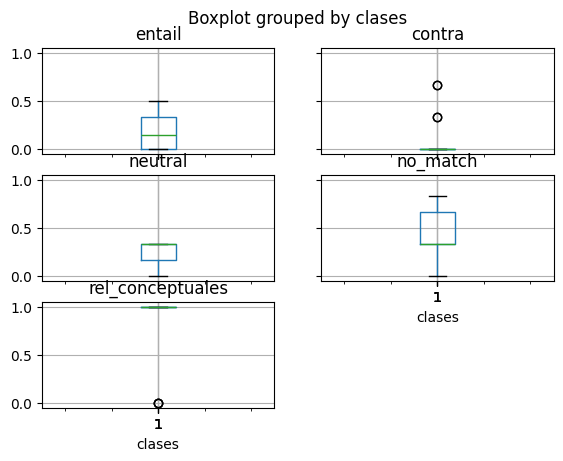

In [ ]:
df_resultados.boxplot(by="clases",column=['entail', 'contra', 'neutral', 'no_match', 'rel_conceptuales'])

# proceos

In [67]:
ma

,station,table,cluband
clothing,-0.008238,0.022620,0.0
orange,0.021178,-0.083560,0.0
metro,0.504996,-0.058719,0.0
person,0.038627,0.051114,0.0
entrance,0.198481,0.061389,0.0
rest,-0.012533,0.090798,0.0


In [68]:
#temp=ma.copy()
for c in ma.columns:
    temp=ma[c][1:].sort_values(ascending=False)
    print(c,temp[:3].values)
    ranks=list(temp[:3].index)
    valranks=list(temp[:3].values)
    for r_i in range(len(ranks)):
        print(c,ranks[r_i],valranks[r_i])
    break


station [0.50499636 0.1984811  0.03862744]
station metro 0.50499636
station entrance 0.1984811
station person 0.038627442


In [70]:
" ".join(ma.idxmax().values)

'metro rest clothing'

In [72]:
" ".join(ma.columns.values)

'station table cluband'

In [83]:
frase1="Some squirrels are mammals."
frase2="No squirrels are mammals."

In [84]:
emb1 = modelSB.encode(frase1)
emb2 = modelSB.encode(frase2)
#Get the cosine similarity score between sentences
cos_sim = util.cos_sim(emb1, emb2)
print(float(cos_sim[0][0]))
#agregar esta parte

0.7555228471755981


In [139]:
frase1="The cat sat on the mat"
frase2="The animal sat on the mat"

In [140]:
emb1 = modelSB.encode(frase1)
emb2 = modelSB.encode(frase2)
#Get the cosine similarity score between sentences
cos_sim = util.cos_sim(emb1, emb2)
print(float(cos_sim[0][0]))
#agregar esta parte

0.7351410984992981


In [141]:
doc1 = nlp(frase1)
doc2 = nlp(frase2)
print(doc1.similarity(doc2))
#
#    bien_me.append(getWDM(st,sh))
#elif st!="" and sh=="":
#    similitud_faltantes.append(1)
#    bien_me.append(0)
#else:
#    similitud_faltantes.append(0)
#    bien_me.append(0)
# 0.8528367657386307

0.9700795397036415


# mutual information

In [116]:
ma

,station,table,cluband
clothing,-0.008238,0.022620,0.0
orange,0.021178,-0.083560,0.0
metro,0.504996,-0.058719,0.0
person,0.038627,0.051114,0.0
entrance,0.198481,0.061389,0.0
rest,-0.012533,0.090798,0.0


In [114]:
m_mi

,station,table,cluband
clothing,3.549515,3.586446,8.135714e-13
orange,3.628371,3.660681,7.656098e-13
metro,3.694917,3.736469,7.345236e-13
person,3.803109,3.830798,6.474821e-13
entrance,3.740643,3.796058,6.936673e-13
rest,3.770016,3.797705,6.714629e-13


In [115]:
m_mi.idxmax()

station      person
table        person
cluband    clothing
dtype: object

# move earts

In [117]:
m_earth

,station,table,cluband
clothing,0.007409,0.008844,0.043478
orange,0.006650,0.011922,0.045438
metro,0.006159,0.005172,0.045585
person,0.007354,0.011560,0.045378
entrance,0.006094,0.005811,0.045739
rest,0.005140,0.005931,0.045659


In [120]:
m_earth.idxmin()

station        rest
table         metro
cluband    clothing
dtype: object